In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl",3))

In [3]:
import matplotlib.style as style
style.use('fivethirtyeight')

In [4]:
pd.options.mode.chained_assignment = None 

In [5]:
#load in the results csv from the modelling notebook
results = pd.read_csv('../CSV/results_df.csv')

In [6]:
results.set_index('Model', drop = True, inplace = True)

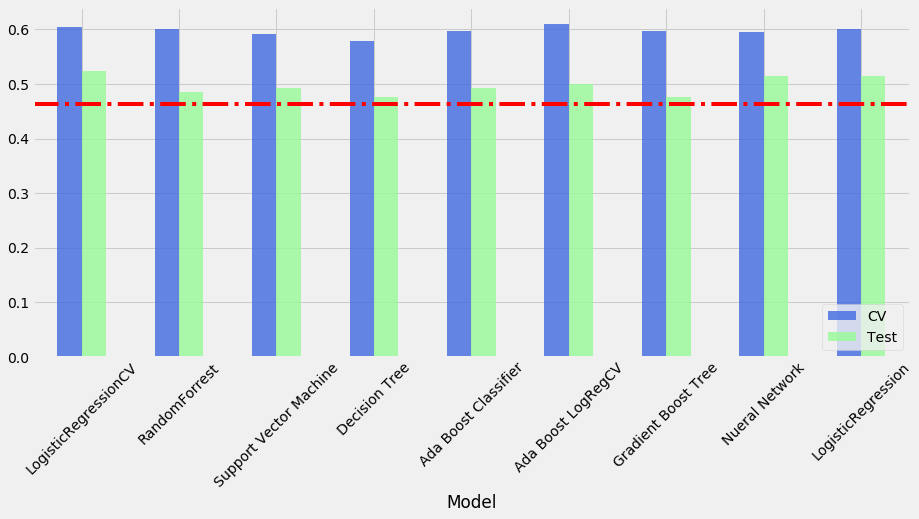

In [7]:
fig, ax = plt.subplots(figsize = (14,6))

results.plot.bar(ax = ax, rot = 45, color = ['royalblue', 'palegreen'], alpha = 0.8);

plt.axhline(y = 0.463462, ls = '-.', c = 'r' , alpha = 1)
plt.legend(loc = 'lower right')
plt.show()

#a visual analysis of how each well each model performed
#the red line is the baseline 

### lets load the data again and re-evaluate the models in more ways than their R2 scores

In [8]:
df = pd.read_csv('../CSV/final_df.csv')

In [9]:
X = df[['HomeTeam', 'AwayTeam',
        'Home_ELO', 'Home_LP', 'Home_Points/Played', 'Home_GD', #'home_decay',
        'home_last_match', 
        'home_last_3', 'home_last_5', 
        'Away_ELO', 'Away_LP', 'Away_Points/Played', 'Away_GD', #'away_decay',
        'away_last_match',
        'away_last_3', 'away_last_5',
        'B365H', 'B365D', 'B365A'
       ]]
y = df.FTR



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class Decay(BaseEstimator, TransformerMixin):
    
    def __init__(self, last_match = 0.8, last_3 = 0.35, last_5 = 0.1, cols = None, cols_to_drop = None):
        self.last_match = last_match
        self.last_3 = last_3
        self.last_5 = last_5
        self.cols = cols
        self.cols_to_drop = cols_to_drop
        
    def make_decay(self, X):
        self.X = X
        home_decay = (self.X[self.cols[0]] * self.last_match) + (self.X[self.cols[1]] * self.last_3) + (self.X[self.cols[2]] * self.last_5)
        home_decay.fillna(0, inplace = True)
        away_decay = (self.X[self.cols[3]] * self.last_match) + (self.X[self.cols[4]] * self.last_3) + (self.X[self.cols[5]] * self.last_5)
        away_decay.fillna(0, inplace = True)
        return home_decay, away_decay
        
    def fit(self, X, *args):
        return self
    
    def transform(self, X, *args):
        X['Home_Decay'] = self.make_decay(X)[0]
        X['Away_Decay'] = self.make_decay(X)[1]
        X = X.drop(columns = self.cols_to_drop)
        return X

In [11]:
def prediction_odds(x, i, DF):
    """ a function to identify the odds of each outcome for each match"""
    if x == 'H':
        return DF.loc[i, 'B365H']
    elif x == 'D':
        return DF.loc[i, 'B365D']
    elif x == 'A':
        return DF.loc[i, 'B365A']

In [12]:
#load in the logistic regression CV model which performed well before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/LRCV_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.5230769230769231


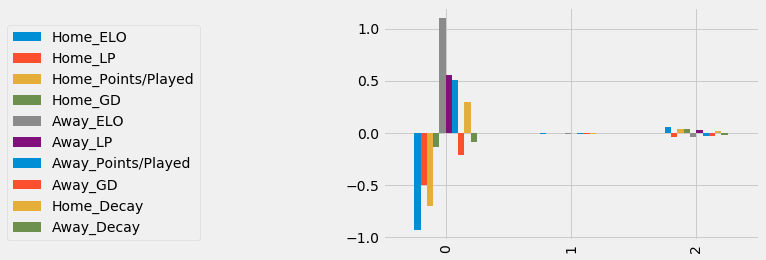

In [13]:
#interestingly the coeficients are only confidently giving weight to the dicision of Home
#this could be expected due to Home being the baseline however the difference in magnitude is greater than anticipated
pd.DataFrame(model.steps[-1][1].coef_, columns = ['Home_ELO', 'Home_LP', 'Home_Points/Played', 'Home_GD',
                                                 'Away_ELO','Away_LP', 'Away_Points/Played', 'Away_GD',
                                                 'Home_Decay', 'Away_Decay']).plot(kind = 'bar');
plt.legend(loc = (-1, 0))
plt.show()

In [14]:
#profit calculation function, importantly all bets were made with the same stake, i.e % returns are calculated
def profit_calculation(model = model, df = df, X_test = X_test):
    """ a function to predict the hypothetical profit made from using a model to bet"""
    test_predictions = model.predict(X_test)
    indices = list(X_test.index)
    cols = ['HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A']
    test_df = df.loc[indices, cols]
    test_df['prediction'] = test_predictions
    bets = []
    for x, i in list(zip(test_df.prediction, indices)):
        bets.append(prediction_odds(x, i, df))
    test_df['bet_odds'] = bets
    test_df['win'] = (test_df.FTR == test_df.prediction)*1
    test_df['profits'] = test_df.bet_odds * test_df.win
    total_profit = (test_df.profits.sum() - len(test_df))
    return total_profit 

In [15]:
def predictor(df, X = X, pipeline = model):
    """ a function that creates an informative df about predicting future matches"""
    T = pd.get_dummies(df)
    missing_cols = set(X.columns) - set(T.columns)
    for c in missing_cols:
        T[c] = 0
    T = T[X.columns]
    df['prediction'] = pipeline.predict(T)
    probs = pipeline.predict_proba(T)
    
    df['Home_prob'] = [x[2] for x in probs]
    df['Draw_prob'] = [x[1] for x in probs]
    df['Away_prob'] = [x[0] for x in probs]
    
    df['Home_odds'] = [1/x[2] for x in probs]
    df['Draw_odds'] = [1/x[1] for x in probs]
    df['Away_odds'] = [1/x[0] for x in probs]
    
    return df.drop(columns = ['Home_Points/Played', 
                              'Away_Points/Played'])

# Now lets evaluate each model

In [16]:
#create lists to store results in
Models = []
Actual = []
Average = []
Percentage = []

Fut_score = []
Fut_profit = []
Fut_pct = []

### Each model's profit/ loss will be calculated along with their predictions of unseen matches, their precison/ recall curves and their ROC curves

## Logistic Regression CV

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/LRCV_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5230769230769231


In [18]:
model = loaded_model

In [19]:
Models.append('Logistic Regression CV')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-7.8799999999999955

In [20]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.06061538461538458

In [21]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [22]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

1.555400000000001

In [23]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

0.011964615384615393

In [24]:
max(money), min(money)

(25.400000000000006, -20.930000000000007)

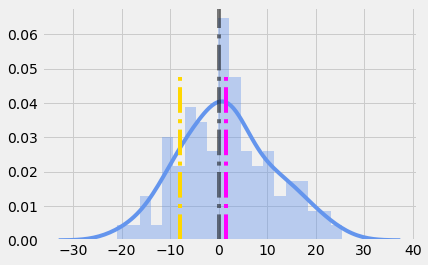

In [25]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [26]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

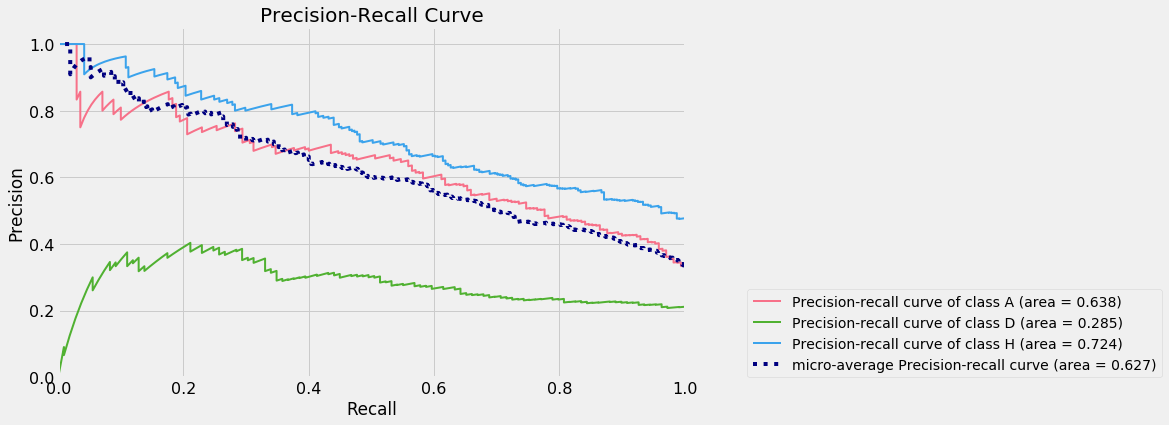

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

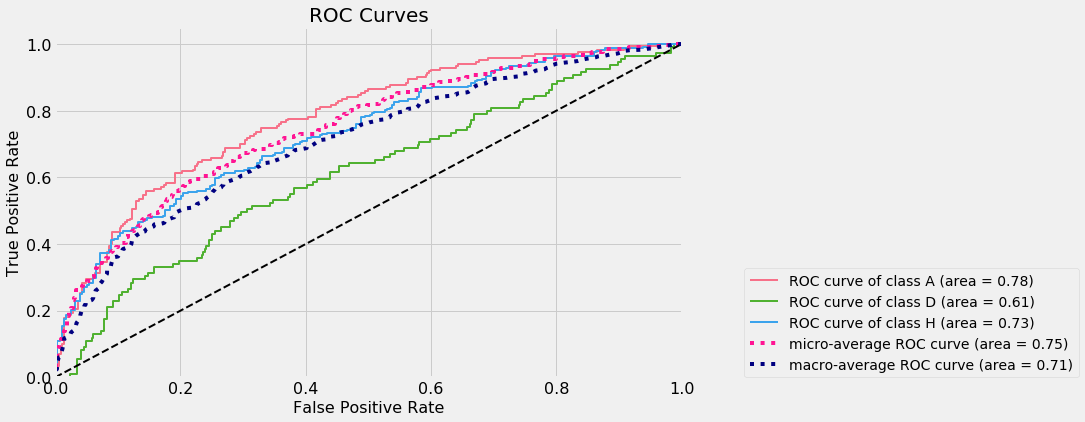

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [29]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,97,0,73
D,19,0,90
H,35,0,206


In [30]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.64      0.57      0.60       170
           D       0.00      0.00      0.00       109
           H       0.56      0.85      0.68       241

    accuracy                           0.58       520
   macro avg       0.40      0.48      0.43       520
weighted avg       0.47      0.58      0.51       520



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [32]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [33]:
Fut_score.append(model.score(fut_X, fut_y ))

In [34]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [35]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.51,0.00,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.48,0.33,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.24,0.33,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.75,0.24,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.41,0.59,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.35,0.33,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.57,0.27,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.75,0.24,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.25,0.33,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.17,0.00,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Random Forrest

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  shuffle = False)
import pickle
filename = '../Models/RF_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.4846153846153846


In [37]:
Models.append('Random Forrest')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-13.990000000000009

In [38]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.10761538461538468

In [39]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [40]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

-6.672399999999997

In [41]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

-0.05132615384615382

In [42]:
max(money), min(money)

(19.569999999999993, -31.49000000000001)

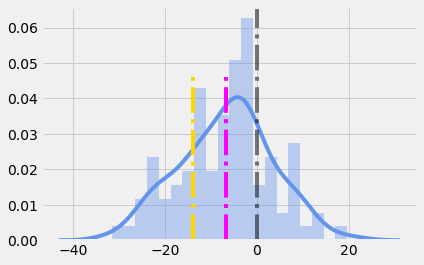

In [43]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [44]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

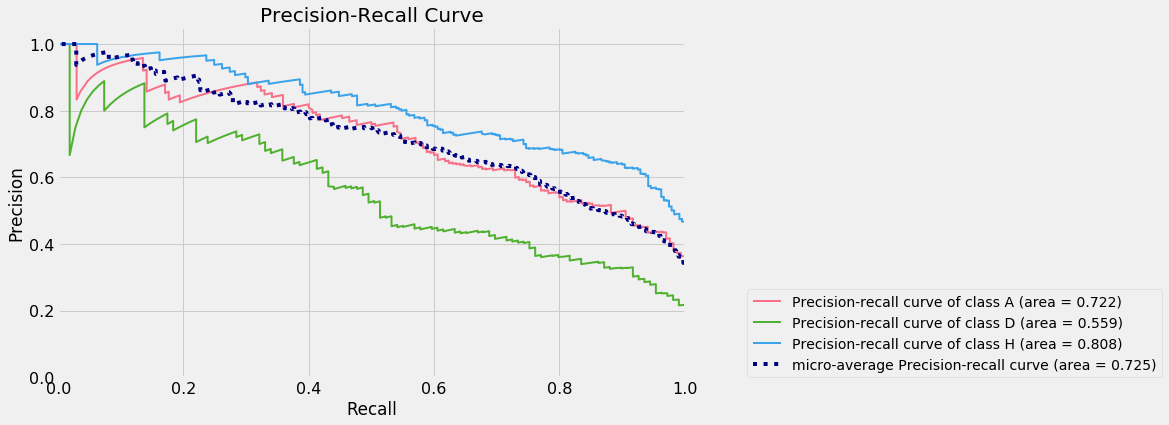

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

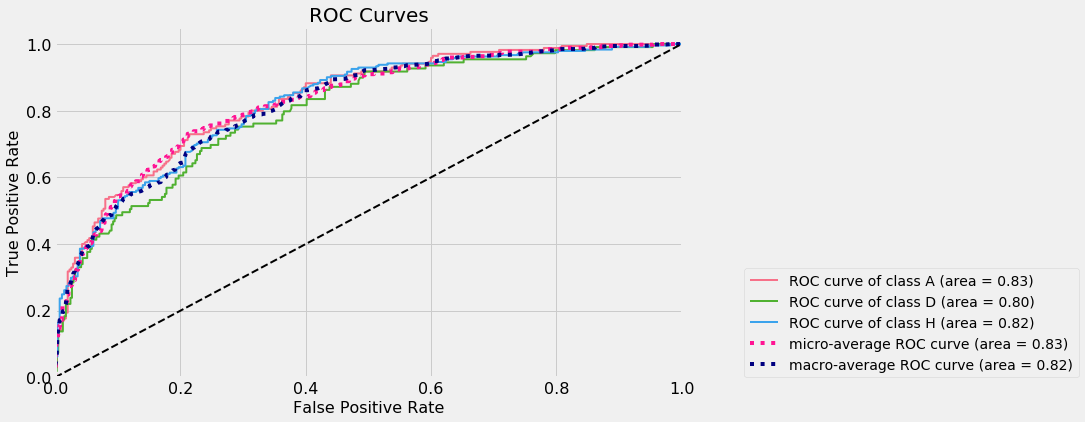

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [47]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,111,4,55
D,26,21,62
H,27,3,211


In [48]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.68      0.65      0.66       170
           D       0.75      0.19      0.31       109
           H       0.64      0.88      0.74       241

    accuracy                           0.66       520
   macro avg       0.69      0.57      0.57       520
weighted avg       0.68      0.66      0.63       520



In [49]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [50]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [51]:
Fut_score.append(model.score(fut_X, fut_y ))

In [52]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [53]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.675,0.000,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.600,0.425,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.300,0.425,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.975,0.300,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.525,0.775,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.475,0.425,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.725,0.375,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.975,0.300,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.325,0.425,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.225,0.000,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Support Vector Machine

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/SVM_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.49230769230769234


In [55]:
Models.append('SVM')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-19.680000000000007

In [56]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.15138461538461545

In [57]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [58]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

-2.023399999999997

In [59]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

-0.01556461538461536

In [60]:
max(money), min(money)

(17.590000000000003, -25.689999999999998)

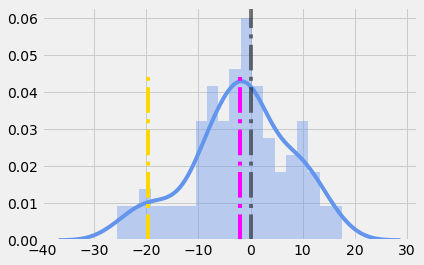

In [61]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [62]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

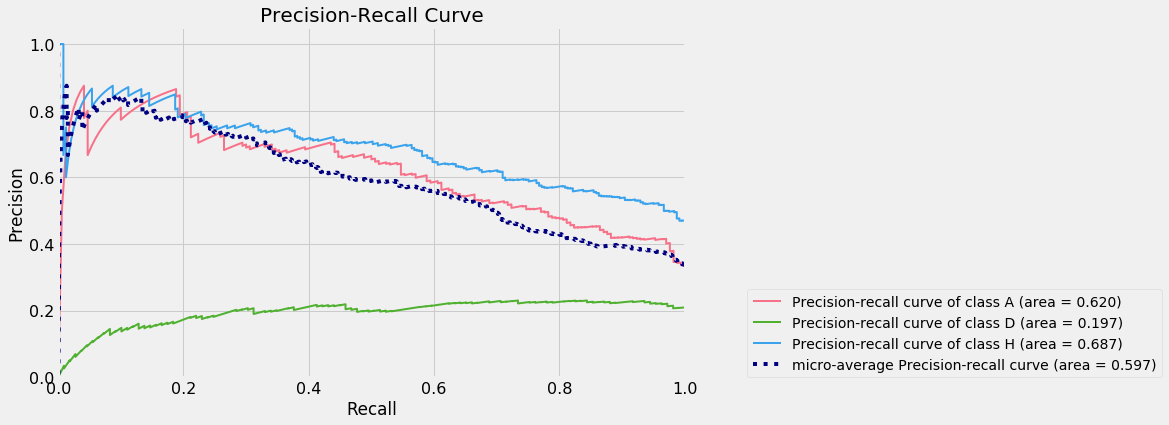

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

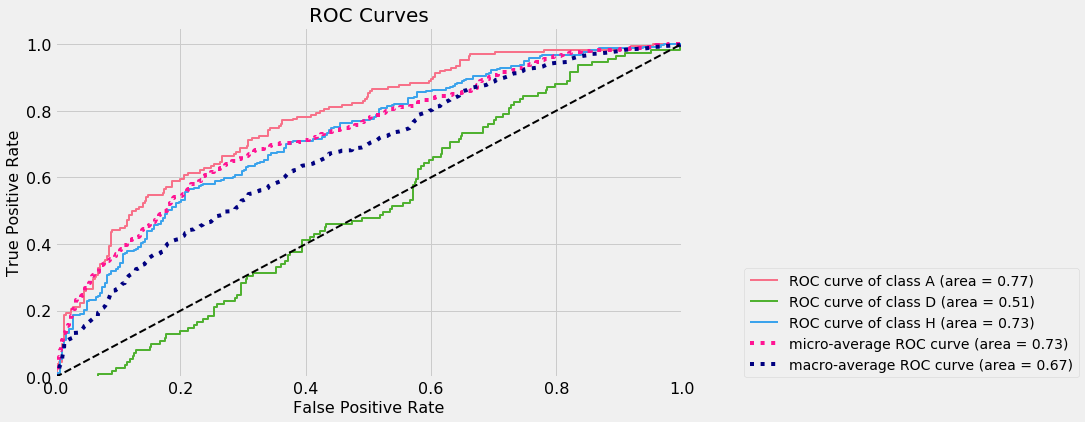

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [65]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,80,0,90
D,15,0,94
H,25,0,216


In [66]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.67      0.47      0.55       170
           D       0.00      0.00      0.00       109
           H       0.54      0.90      0.67       241

    accuracy                           0.57       520
   macro avg       0.40      0.46      0.41       520
weighted avg       0.47      0.57      0.49       520



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [68]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [69]:
Fut_score.append(model.score(fut_X, fut_y ))

In [70]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [71]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.51,0.00,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.48,0.33,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.24,0.33,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.75,0.24,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.41,0.59,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.35,0.33,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.57,0.27,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.75,0.24,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.25,0.33,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.17,0.00,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Decision Tree

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/DTC_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.47692307692307695


In [73]:
Models.append('Decision Tree')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-22.58

In [74]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.17369230769230767

In [75]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [76]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

-6.204900000000001

In [77]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

-0.04773000000000001

In [78]:
max(money), min(money)

(30.110000000000014, -36.69)

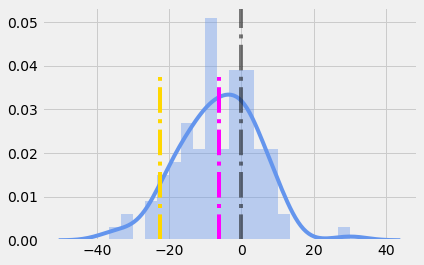

In [79]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [80]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

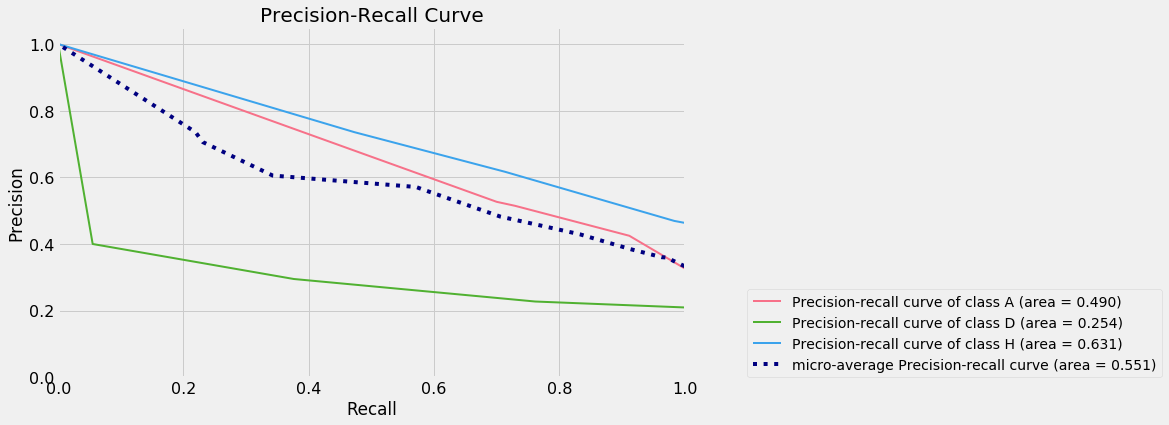

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

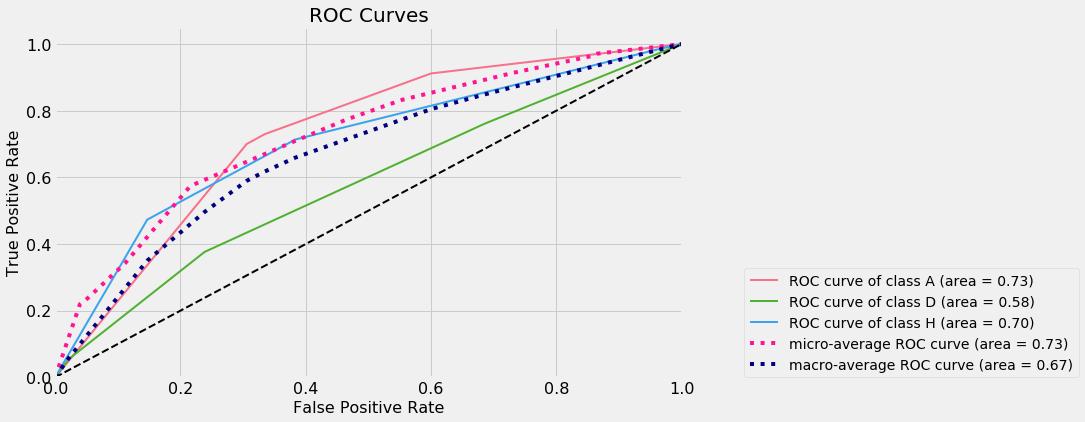

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [83]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,119,5,46
D,42,6,61
H,65,4,172


In [84]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.53      0.70      0.60       170
           D       0.40      0.06      0.10       109
           H       0.62      0.71      0.66       241

    accuracy                           0.57       520
   macro avg       0.51      0.49      0.45       520
weighted avg       0.54      0.57      0.52       520



In [85]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [86]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [87]:
Fut_score.append(model.score(fut_X, fut_y ))

In [88]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [89]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.51,0.00,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.48,0.33,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.24,0.33,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.75,0.24,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.41,0.59,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.35,0.33,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.57,0.27,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.75,0.24,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.25,0.33,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.17,0.00,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Ada Boost Decision Tree

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/AdaBoost_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.49230769230769234


In [91]:
Models.append('Ada Decision Tree Boost')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-20.730000000000004

In [92]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.1594615384615385

In [93]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [94]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

-3.1879000000000017

In [95]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

-0.024522307692307704

In [96]:
max(money), min(money)

(25.629999999999995, -30.980000000000004)

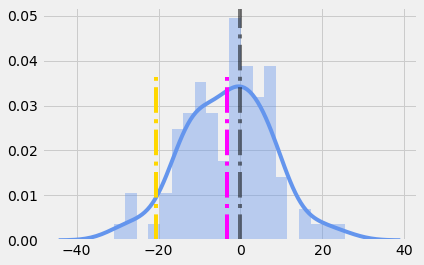

In [97]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [98]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

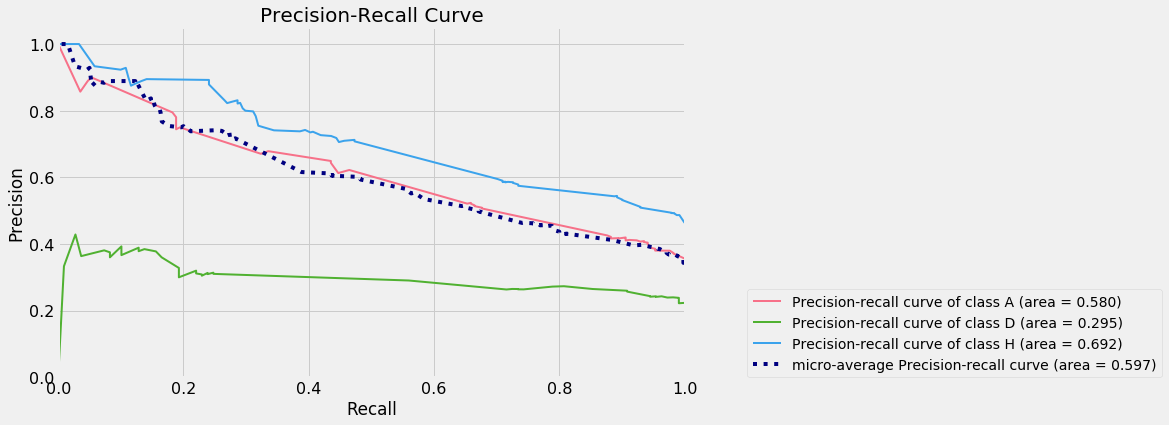

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

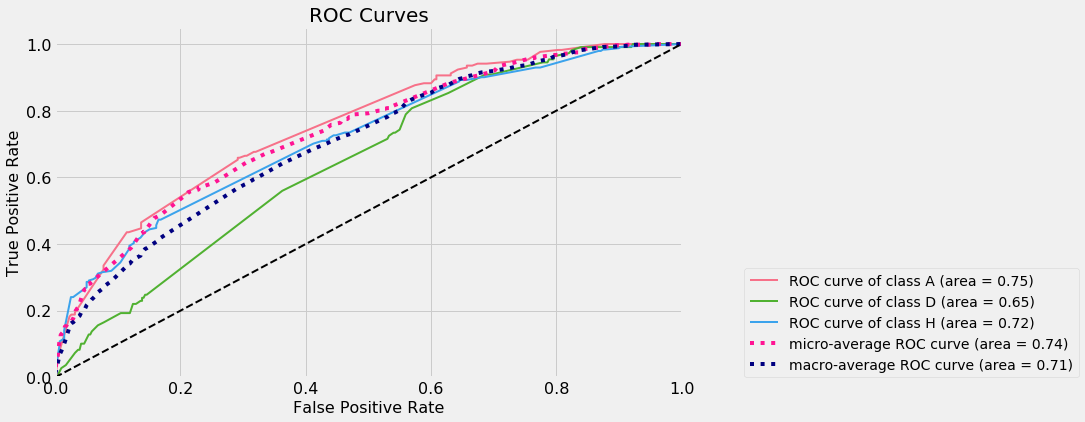

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [101]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,77,0,93
D,22,0,87
H,26,0,215


In [102]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.62      0.45      0.52       170
           D       0.00      0.00      0.00       109
           H       0.54      0.89      0.68       241

    accuracy                           0.56       520
   macro avg       0.39      0.45      0.40       520
weighted avg       0.45      0.56      0.48       520



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [104]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [105]:
Fut_score.append(model.score(fut_X, fut_y ))

In [106]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [107]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.70,0.03,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.68,0.48,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.39,0.46,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,1.08,0.34,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.60,0.82,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.48,0.47,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.82,0.38,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,1.08,0.35,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.40,0.48,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.26,0.04,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Ada Boost Logistic Regression CV

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/AdaBoost_LRCV_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.5


In [109]:
Models.append('Ada LogReg CV Boost')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-15.300000000000011

In [110]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.11769230769230778

In [111]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [112]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

2.5734

In [113]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

0.019795384615384614

In [114]:
max(money), min(money)

(29.200000000000017, -20.599999999999994)

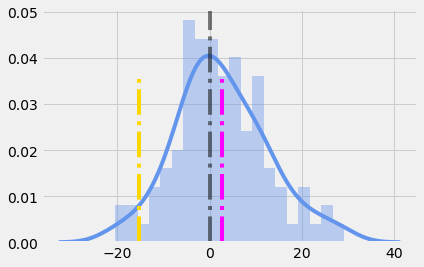

In [115]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [116]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

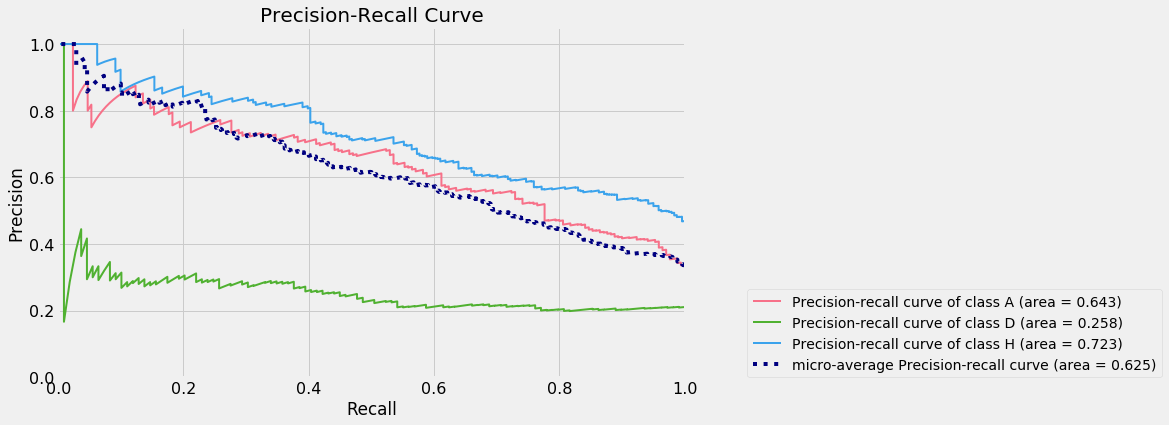

In [117]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

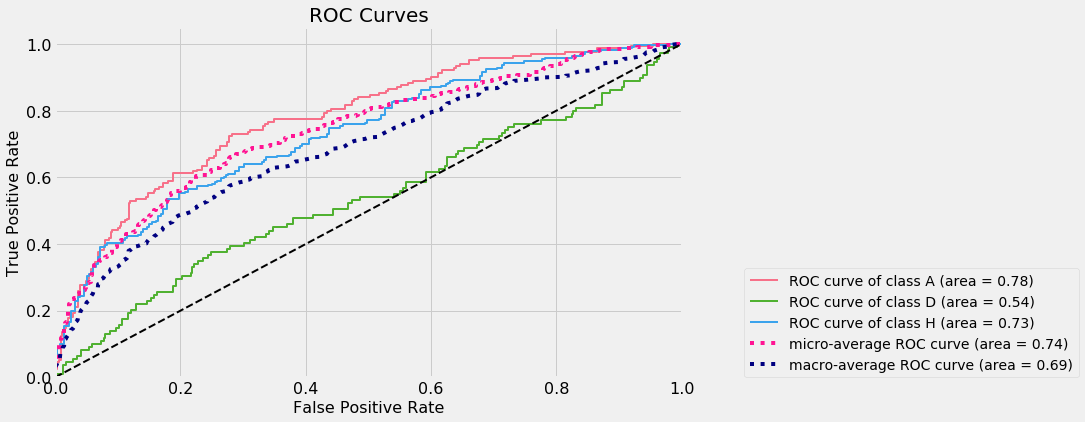

In [118]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [119]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,95,0,75
D,21,0,88
H,36,0,205


In [120]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.62      0.56      0.59       170
           D       0.00      0.00      0.00       109
           H       0.56      0.85      0.67       241

    accuracy                           0.58       520
   macro avg       0.39      0.47      0.42       520
weighted avg       0.46      0.58      0.50       520



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [122]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [123]:
Fut_score.append(model.score(fut_X, fut_y ))

In [124]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [125]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.590,0.015,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.520,0.380,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.285,0.370,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.870,0.260,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.470,0.680,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.420,0.375,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.640,0.340,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.870,0.265,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.310,0.380,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.210,0.020,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Gradient Boost Classifier

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/GradBoost_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.47692307692307695


In [127]:
Models.append('Grad Boost')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-18.599999999999994

In [128]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.14307692307692305

In [129]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [130]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

-5.038399999999999

In [131]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

-0.03875692307692307

In [132]:
max(money), min(money)

(24.189999999999998, -27.22)

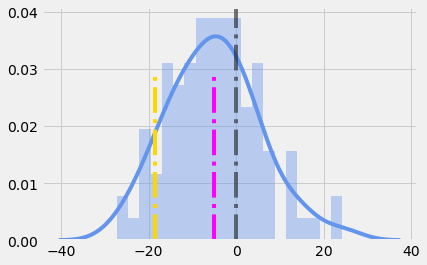

In [133]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [134]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

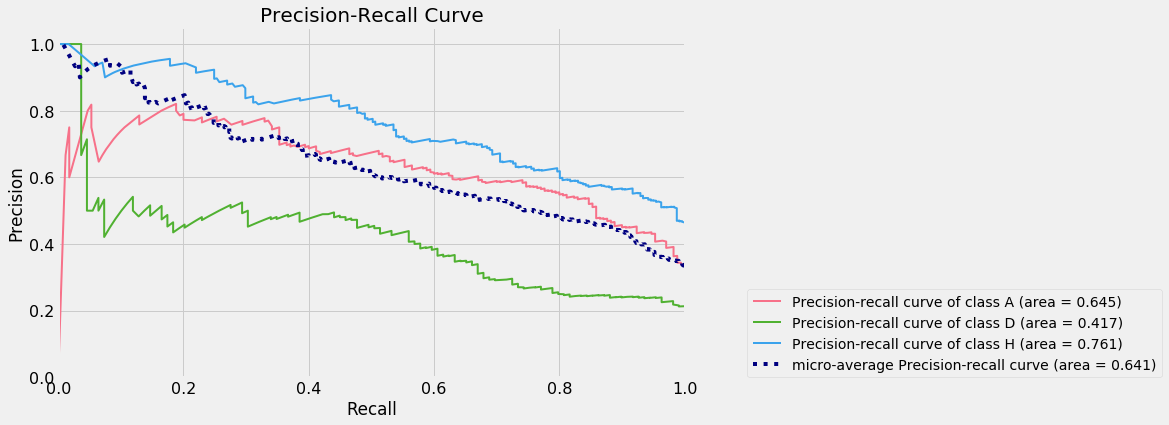

In [135]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

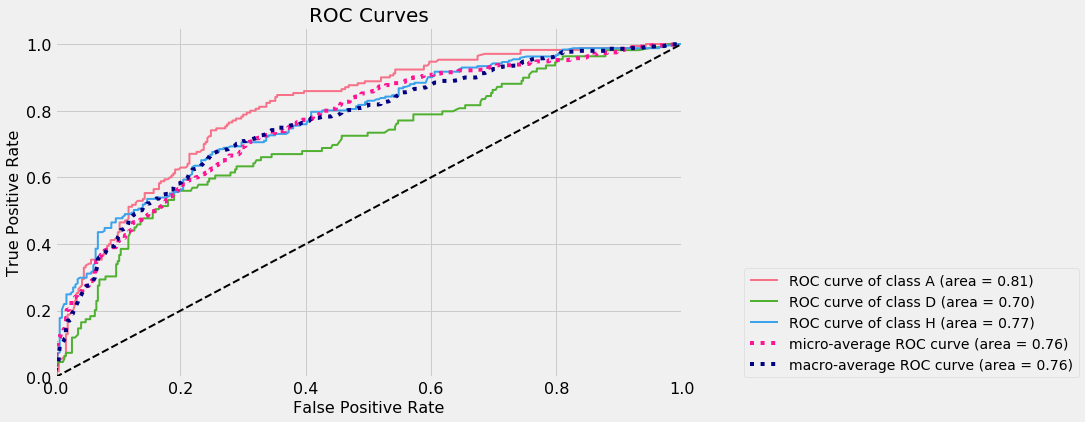

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [137]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,76,0,94
D,18,0,91
H,23,0,218


In [138]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.65      0.45      0.53       170
           D       0.00      0.00      0.00       109
           H       0.54      0.90      0.68       241

    accuracy                           0.57       520
   macro avg       0.40      0.45      0.40       520
weighted avg       0.46      0.57      0.49       520



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [140]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [141]:
Fut_score.append(model.score(fut_X, fut_y ))

In [142]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [143]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.63,0.00,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.60,0.41,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.30,0.41,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.93,0.30,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.51,0.73,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.43,0.41,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.71,0.33,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.93,0.30,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.31,0.41,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.21,0.00,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Neural Network

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/NNet_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.5153846153846153


In [145]:
Models.append('Neural Network')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-10.580000000000013

In [146]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.08138461538461549

In [147]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [148]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

-4.000900000000001

In [149]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

-0.03077615384615385

In [150]:
max(money), min(money)

(29.029999999999973, -32.43000000000001)

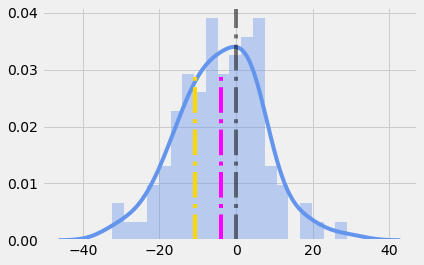

In [151]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [152]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

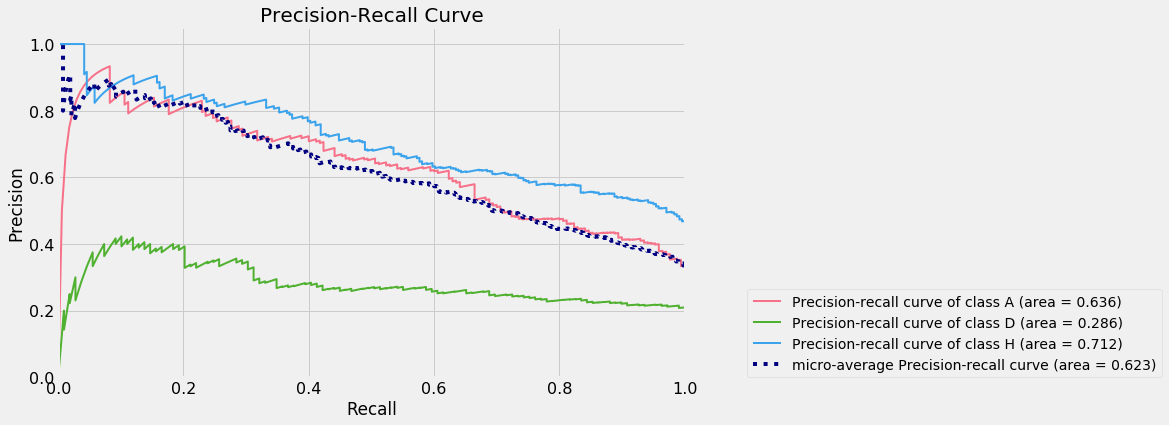

In [153]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

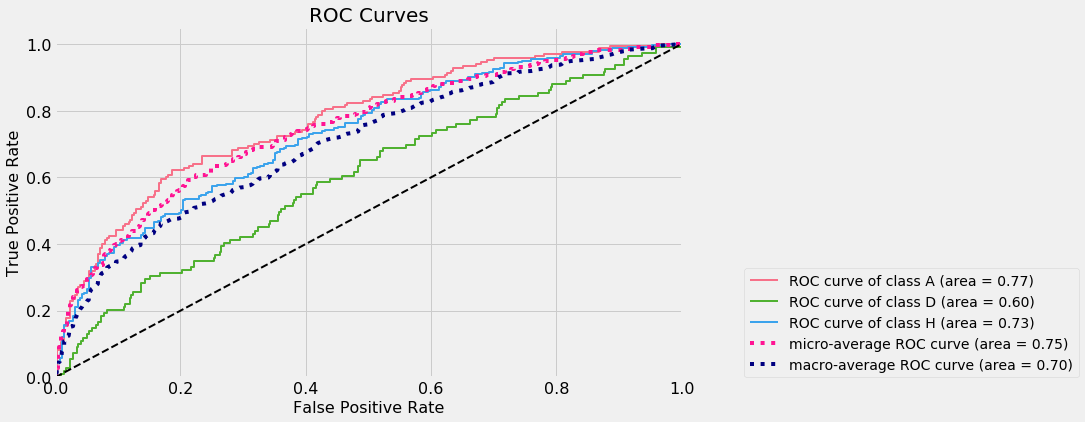

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [155]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,103,4,63
D,24,5,80
H,41,6,194


In [156]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.61      0.61      0.61       170
           D       0.33      0.05      0.08       109
           H       0.58      0.80      0.67       241

    accuracy                           0.58       520
   macro avg       0.51      0.49      0.45       520
weighted avg       0.54      0.58      0.53       520



In [157]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [158]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [159]:
Fut_score.append(model.score(fut_X, fut_y ))

In [160]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [161]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0.63,0.00,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0.48,0.37,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0.24,0.37,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0.87,0.24,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0.45,0.71,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0.47,0.37,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0.61,0.39,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0.87,0.24,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0.29,0.37,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0.21,0.00,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


## Logistic Regression

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)
import pickle
filename = '../Models/LR_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
model = loaded_model

0.5153846153846153


In [163]:
Models.append('Logistic Regression')
actual = profit_calculation(model = model, X_test = X_test) 
Actual.append(actual)
actual

-9.13000000000001

In [164]:
profit_calculation(model = model, X_test = X_test) /len(X_test)

-0.0702307692307693

In [165]:
money = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =i, shuffle = True)
    
    model.fit(X_train, y_train)
    
    money.append(profit_calculation(model = model, X_test = X_test))

In [166]:
mean = (sum(money) / len(money)) 
Average.append(mean)
mean

1.6218999999999997

In [167]:
pct_return = (sum(money) / len(money)) /len(X_test)
Percentage.append(pct_return)
pct_return

0.012476153846153843

In [168]:
max(money), min(money)

(27.789999999999992, -22.099999999999994)

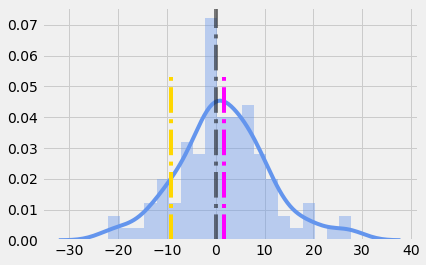

In [169]:
sns.distplot(money, bins = 20, color = 'cornflowerblue');
plt.axvline(0, 0,1, c= 'k', ls = '-.', alpha = 0.5)
plt.axvline(mean, 0,0.7, c= 'fuchsia', ls = '-.')
plt.axvline(actual, 0,0.7, c= 'gold', ls = '-.')
plt.show()

In [170]:
predictions = model.predict(X)
probabilities = model.predict_proba(X)

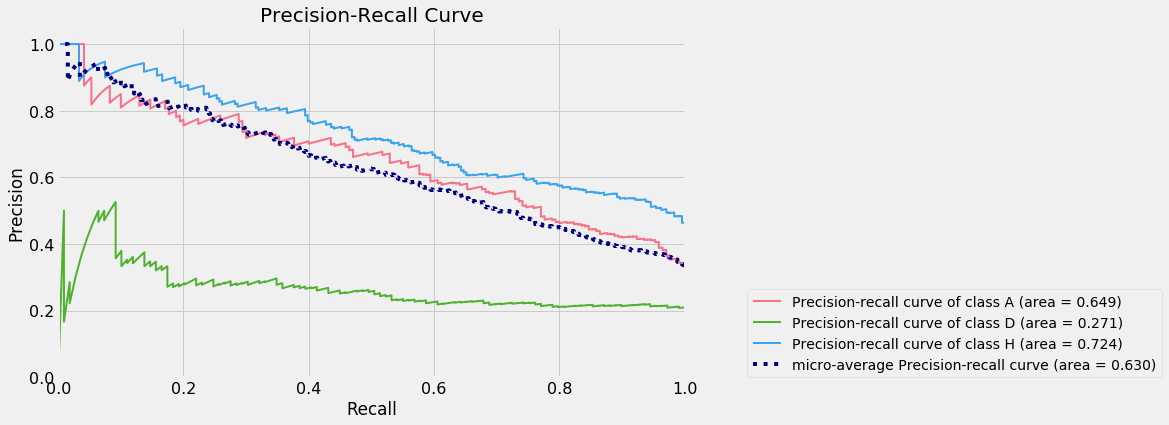

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_precision_recall(y, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

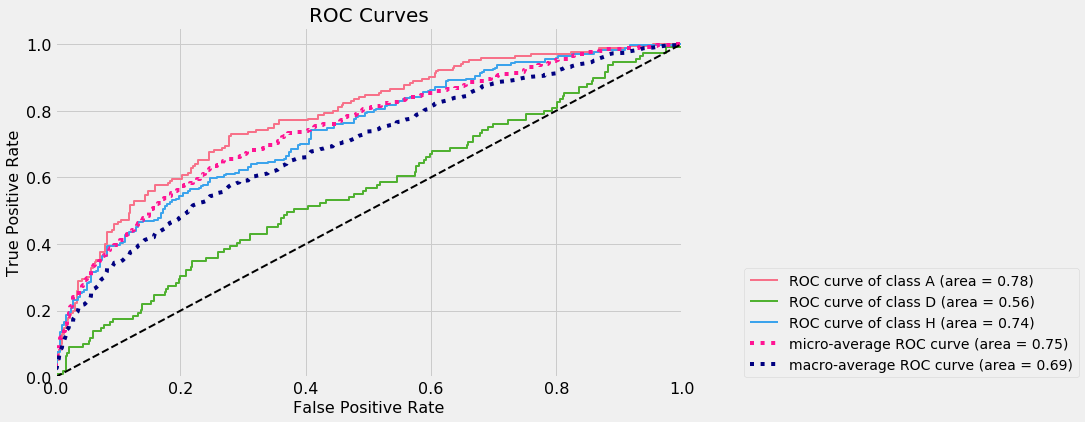

In [172]:
fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_roc(y, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax)
ax.legend(loc=[1.1,0])
plt.show()

In [173]:
pd.DataFrame(confusion_matrix(y, predictions), columns = model.steps[-1][1].classes_,
                                                         index = model.steps[-1][1].classes_)

,A,D,H
A,99,0,71
D,23,0,86
H,41,0,200


In [174]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           A       0.61      0.58      0.59       170
           D       0.00      0.00      0.00       109
           H       0.56      0.83      0.67       241

    accuracy                           0.57       520
   macro avg       0.39      0.47      0.42       520
weighted avg       0.46      0.57      0.50       520



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [175]:
future_test = pd.read_csv('../CSV/weekend_matches.csv')

In [176]:
fut_y = future_test.pop('FTR')
fut_X = future_test

In [177]:
Fut_score.append(model.score(fut_X, fut_y ))

In [178]:
Fut_profit.append(profit_calculation(model = model, X_test = fut_X))
Fut_pct.append((profit_calculation(model = model, X_test = fut_X) * 100) / len(fut_X))

In [179]:
predictor(future_test, X = fut_X)

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,Away_LP,...,B365A,Home_Decay,Away_Decay,prediction,Home_prob,Draw_prob,Away_prob,Home_odds,Draw_odds,Away_odds
0,Crystal Palace,Bournemouth,1737,11,-5,3,6,7,1683,12,...,3.36,0,0,H,0.508753,0.197006,0.294241,1.965590,5.075993,3.398575
1,Burnley,Man City,1684,10,0,0,6,8,1995,3,...,1.24,0,0,A,0.299062,0.129582,0.571355,3.343786,7.717095,1.750224
2,Chelsea,Aston Villa,1869,4,8,0,3,9,1642,15,...,8.47,0,0,H,0.663984,0.240766,0.095251,1.506061,4.153419,10.498615
3,Leicester,Watford,1821,2,24,3,9,15,1627,20,...,8.55,0,0,H,0.616857,0.205163,0.177980,1.621120,4.874179,5.618612
4,Man United,Tottenham,1795,9,4,1,5,9,1840,5,...,2.82,0,0,H,0.480371,0.193769,0.325860,2.081722,5.160797,3.068803
5,Southampton,Norwich,1639,18,-17,3,4,5,1604,19,...,4.60,0,0,H,0.479853,0.196146,0.324002,2.083973,5.098252,3.086403
6,Wolves,West Ham,1745,6,2,1,7,11,1702,13,...,5.28,0,0,H,0.467349,0.176556,0.356095,2.139729,5.663928,2.808238
7,Liverpool,Everton,2044,1,20,3,9,15,1701,17,...,5.71,0,0,H,0.717694,0.229910,0.052396,1.393351,4.349537,19.085300
8,Sheffield United,Newcastle,1673,7,4,1,3,9,1698,14,...,5.18,0,0,H,0.445085,0.174612,0.380303,2.246762,5.726972,2.629485
9,Arsenal,Brighton,1813,8,-1,1,2,5,1632,16,...,5.13,0,0,H,0.606688,0.228013,0.165299,1.648293,4.385717,6.049648


# Analysis of Models

In [180]:
pct = [i * 100 for i in Percentage]
pct

[1.1964615384615394,
 -5.132615384615382,
 -1.5564615384615361,
 -4.773000000000001,
 -2.4522307692307703,
 1.9795384615384615,
 -3.875692307692307,
 -3.077615384615385,
 1.2476153846153843]

In [181]:
returns = pd.DataFrame({
    'Model': Models,
    'Test Return': Actual,
    'Average Return': Average,
    'Percentage Return': pct
})

In [182]:
returns
#although none of the models were in the green, the average returns from shuffled data provided more positive results
#The fact that all the models lost a fair amount suggests that the test data could have been a period of very unpredictable football

,Model,Test Return,Average Return,Percentage Return
0,Logistic Regression CV,-7.88,1.5554,1.196462
1,Random Forrest,-13.99,-6.6724,-5.132615
2,SVM,-19.68,-2.0234,-1.556462
3,Decision Tree,-22.58,-6.2049,-4.773000
4,Ada Decision Tree Boost,-20.73,-3.1879,-2.452231
5,Ada LogReg CV Boost,-15.30,2.5734,1.979538
6,Grad Boost,-18.60,-5.0384,-3.875692
7,Neural Network,-10.58,-4.0009,-3.077615
8,Logistic Regression,-9.13,1.6219,1.247615


In [183]:
returns.set_index('Model', drop = True, inplace = True)

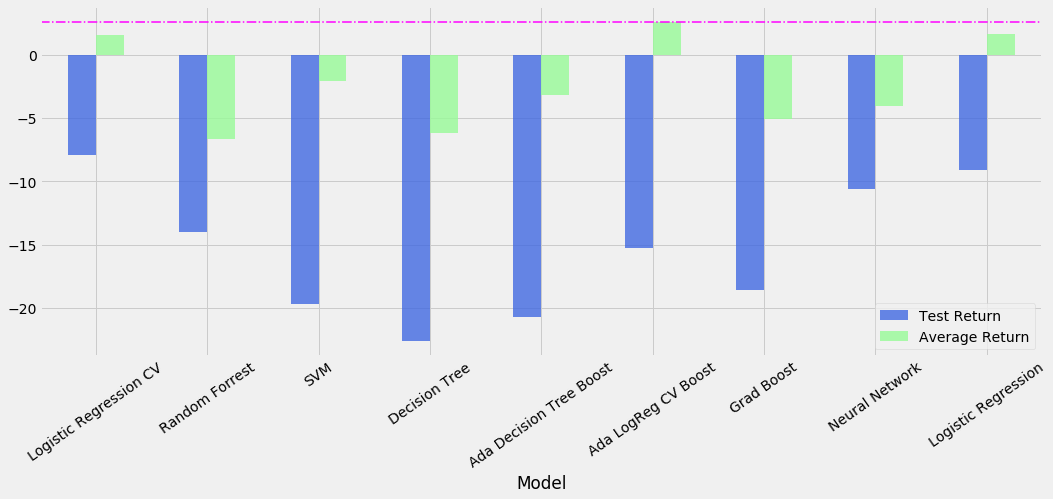

In [184]:
fig, ax = plt.subplots(figsize = (16,6))

returns[['Test Return', 'Average Return']].plot.bar(ax = ax, rot = 35, color = ['royalblue', 'palegreen'], alpha = 0.8);
plt.axhline(y = 2.5734, ls = '-.', c = 'fuchsia' , alpha = 1, lw = 1.5)
plt.legend(loc = 'lower right')
plt.show()

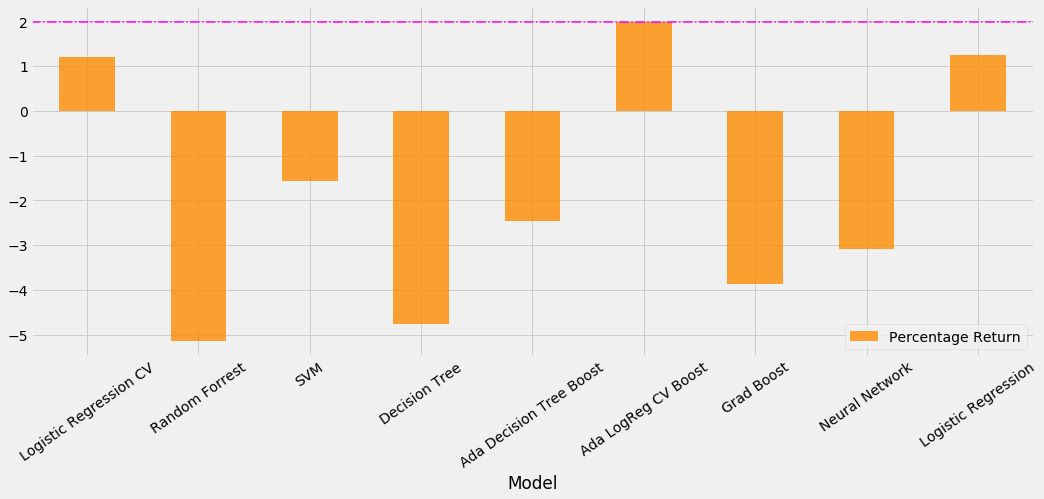

In [185]:
fig, ax = plt.subplots(figsize = (16,6))

returns[['Percentage Return']].plot.bar(ax = ax, rot = 35, color = ['darkorange'], alpha = 0.8);
plt.axhline(y = 1.979538, ls = '-.', c = 'fuchsia' , alpha = 1, lw = 1.5)
plt.legend(loc = 'lower right')
plt.show()

In [186]:
#collect the results of the blind test and put into a data frame

future_test = pd.DataFrame({
    'Model': Models,
    'Score': Fut_score,
    'Return': Fut_profit,
    'Percentage Return': Fut_pct
})

In [187]:
future_test.set_index('Model', drop = True, inplace = True)

In [188]:
future_test

,Score,Return,Percentage Return
Model,,,
Logistic Regression CV,0.65,0.11,0.55
Random Forrest,0.65,-1.14,-5.70
SVM,0.60,0.71,3.55
Decision Tree,0.60,-3.81,-19.05
Ada Decision Tree Boost,0.65,1.05,5.25
Ada LogReg CV Boost,0.70,-0.54,-2.70
Grad Boost,0.70,3.51,17.55
Neural Network,0.65,2.15,10.75
Logistic Regression,0.70,-0.54,-2.70


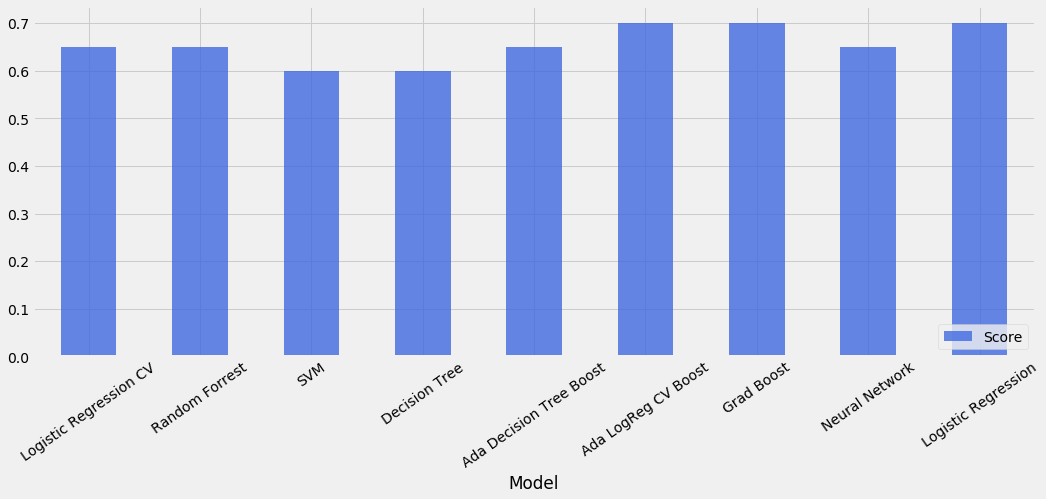

In [189]:
#although the limited size of the test set doesn't allow for much variation between scores
#it is clear that models such as random forrest, SVM and Decision Trees are unsuited to this type of test data

fig, ax = plt.subplots(figsize = (16,6))

future_test[['Score']].plot.bar(ax = ax, rot = 35, color = ['royalblue'], alpha = 0.8);
#plt.axhline(y = 2.5734, ls = '-.', c = 'fuchsia' , alpha = 1, lw = 1.5)
plt.legend(loc = 'lower right')
plt.show()

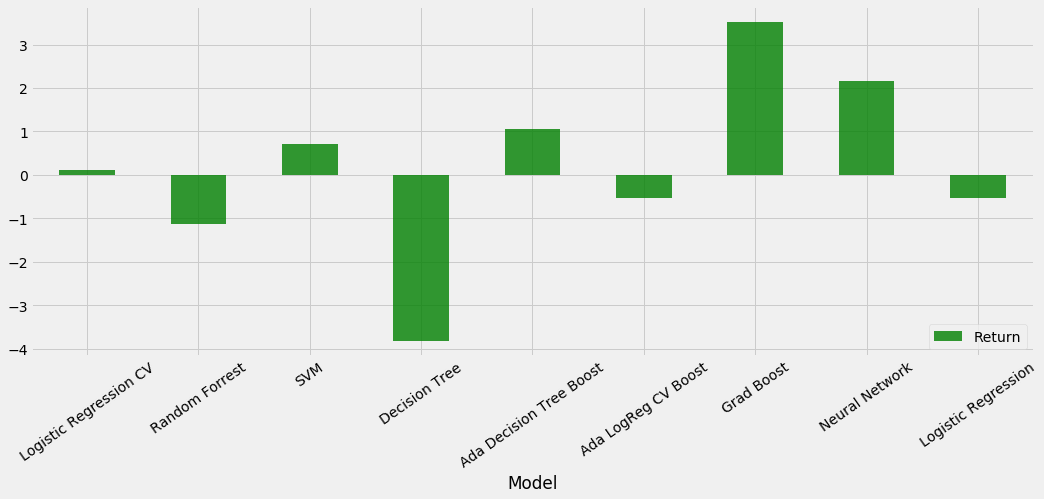

In [190]:
#Strangely there isn't a direct correlation between accuracy and profit, even over a 20 match test set.
#Whilst the Ada LogReg CV Boost model and the plain logistic regression model were the most accuracte,
#they both lost money over the 20 matches whilst other models made decent amounts
#this large profit could be due to a wildcard coming off but then again those sorts of bets are the most profitable ones

fig, ax = plt.subplots(figsize = (16,6))

future_test[['Return']].plot.bar(ax = ax, rot = 35, color = ['green'], alpha = 0.8);
#plt.axhline(y = 2.5734, ls = '-.', c = 'fuchsia' , alpha = 1, lw = 1.5)
plt.legend(loc = 'lower right')
plt.show()

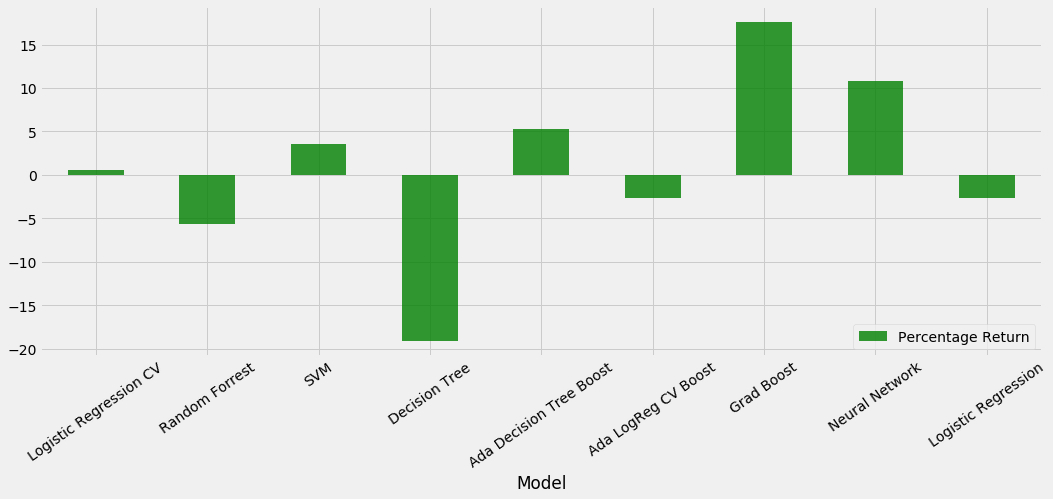

In [191]:
fig, ax = plt.subplots(figsize = (16,6))

future_test[['Percentage Return']].plot.bar(ax = ax, rot = 35, color = ['green'], alpha = 0.8);
#plt.axhline(y = 2.5734, ls = '-.', c = 'fuchsia' , alpha = 1, lw = 1.5)
plt.legend(loc = 'lower right')
plt.show()